# In class coding workshop

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natrask/ENM5320-2026/blob/main/NewMaterial/Lecture06_Feb05/inclass.ipynb)

In [3]:
import torch

Today we will be working through some basic PyTorch exercises to make sure that we're all in good shape to start machine learning finite difference discretizations. In this class we will learn two types of finite difference models:

**Time unsteady discretizations:**

$$\frac{u^{n+1}_j - u^n_j}{k} = \mathcal{D}_+ \mathcal{D}_- u|_j + \mathcal{N}[u]|_j$$

**Steady discretizations:**
$$\mathcal{D}_+ \mathcal{D}_- u|_j + \mathcal{N}[u]|_j = 0$$

The first we can march forward in time, and depending on whether the right hand side is treated **explicitly** (i.e. discretized at $t^n$) or **implicitly** (i.e. discretized at $t^{n+1}$).

- For the explicit case, we can march through and update the solution at each timestep.
- For the implicit case we will need to solve a system of equations to identify the update at each timestep (we did this in HW1).
- For the steady case we will just solve the system of equations once to get the final solution.

In order to fit a model to data, we will set pytorch up to propagate derivatives through this solution so that we can identify stencils consistent with data. To do that, we will need to be able to solve a nonlinear system. 

Today we will step through two exercises to make sure you have the background needed to write these three flavors of solver:
1. We'll learn how to implement Newton optimization with Armijo's rule for backtracking. This is a robust way to solve nonlinear systems of equations, and we'll learn how to use PyTorch to compute the necessary derivatives.
2. We'll take our finite difference code from HW1 and show how to use PyTorch to train for a simple linear finite difference stencil.

In a future in-class exercise we will combine both of these so that we can train a **non-linear** stencil.


# Part 1. Solving nonlinear systems with Newton + Backtracking

## Overview

### Newton's Method for Vector-Valued Functions

**Newton's Method** is an iterative technique for solving systems of nonlinear equations $\mathbf{F}(\mathbf{x}) = \mathbf{0}$, where $\mathbf{F}: \mathbb{R}^n \to \mathbb{R}^n$.

#### Algorithm

Starting from an initial guess $\mathbf{x}_0$, we generate iterates by solving:

$$\mathbf{J}(\mathbf{x}_k) \Delta \mathbf{x}_k = -\mathbf{F}(\mathbf{x}_k)$$

then updating:

$$\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha \Delta \mathbf{x}_k$$

where $\mathbf{J}(\mathbf{x}_k)$ is the **Jacobian matrix**:

$$\mathbf{J}(\mathbf{x}) = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial x_1} & \cdots & \frac{\partial f_n}{\partial x_n}
\end{bmatrix}$$

and $\alpha \in [0,1]$ is a *relaxation parameter* that is set to $1$ for the standard Newton's method.

#### Properties

- **Quadratic convergence** near the solution when $\mathbf{J}(\mathbf{x}^*)$ is nonsingular
- Requires good initial guess within the basin of attraction
- May fail if Jacobian is singular or initial guess is poor
- Full Newton steps use $\alpha = 1$, but this can overshoot when far from solution

#### Stopping Criteria

Common convergence tests:
- $\|\mathbf{F}(\mathbf{x}_k)\| < \epsilon$ (residual is small)
- $\|\Delta \mathbf{x}_k\| < \epsilon$ (step size is small)
- Maximum iterations reached

---

### Armijo's Rule (Backtracking Line Search)

**Armijo's Rule** determines an appropriate step size to ensure sufficient decrease, improving global convergence of Newton's method.

#### The Basic Idea

Instead of always taking the full Newton step, we use:

$$\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha_k \Delta \mathbf{x}_k$$

where $\alpha_k \in (0, 1]$ is chosen to satisfy the **Armijo condition**.

#### For Nonlinear Systems

We define a **merit function** (measuring progress toward the solution):

$$\phi(\mathbf{x}) = \frac{1}{2} \|\mathbf{F}(\mathbf{x})\|^2$$

Armijo's rule finds $\alpha$ such that:

$$\phi(\mathbf{x}_k + \alpha \Delta \mathbf{x}_k) \leq \phi(\mathbf{x}_k) + c_1 \alpha \nabla \phi(\mathbf{x}_k)^T \Delta \mathbf{x}_k$$

where:
- $c_1 \in (0, 1)$ is a parameter (typically $c_1 = 10^{-4}$)
- $\nabla \phi(\mathbf{x}_k) = \mathbf{J}(\mathbf{x}_k)^T \mathbf{F}(\mathbf{x}_k)$
- The directional derivative is: $\nabla \phi(\mathbf{x}_k)^T \Delta \mathbf{x}_k = -\|\mathbf{F}(\mathbf{x}_k)\|^2$ (using the Newton step)

#### Backtracking Algorithm

```python
α = 1.0  # Start with full Newton step
τ = 0.5  # Backtracking factor
c₁ = 1e-4

while φ(xₖ + α Δxₖ) > φ(xₖ) + c₁ α ∇φ(xₖ)ᵀ Δxₖ:
    α = τ * α  # Reduce step size
```

#### Benefits

- **Global convergence**: Can converge from poor initial guesses
- **Robustness**: Prevents divergence from overshooting
- **Adaptive**: Automatically adjusts step size to function behavior
- **Efficient**: Typically accepts $\alpha = 1$ near the solution (preserving quadratic convergence)
- **Simple**: Only requires function evaluations (no additional derivatives)

#### Combined Newton-Armijo Method

1. Compute Newton step: $\mathbf{J}(\mathbf{x}_k) \Delta \mathbf{x}_k = -\mathbf{F}(\mathbf{x}_k)$
2. Use Armijo backtracking to find $\alpha_k$
3. Update: $\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha_k \Delta \mathbf{x}_k$
4. Check convergence; repeat if needed

This combination provides both the fast local convergence of Newton's method and better global behavior from line search.

## Exercise. Use jacrev to compute Jacobians and solve a nonlinear system

We are going to step through coding this up in PyTorch. Remember that PyTorch at its core is just a tool for **computing derivatives**, and so we can use it to build a Jacobian automatically.

To practice this, we will solve the system of nonlinear equations:

$$\begin{align}
f_1(x, y) &= x^2 + y^2 - 4 = 0 \\
f_2(x, y) &= x^2 - y - 1 = 0
\end{align}$$

**Interpretation:** This system represents:
- A circle of radius 2 centered at the origin: $x^2 + y^2 = 4$
- A parabola: $y = x^2 - 1$

We're looking for the intersection points of these two curves.

**Analytical Solution:** Substituting $y = x^2 - 1$ into the first equation:
$$x^2 + (x^2 - 1)^2 = 4$$
$$x^2 + x^4 - 2x^2 + 1 = 4$$
$$x^4 - x^2 - 3 = 0$$

This gives us $x^2 = \frac{1 \pm \sqrt{13}}{2}$, so there are solutions at approximately $(±1.303, 0.697)$ and $(±0.786, -0.382)$.

**Jacobian:** For Newton's method, we need:

$$\mathbf{J}(x, y) = \begin{bmatrix}
\frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} \\
\frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y}
\end{bmatrix} = \begin{bmatrix}
2x & 2y \\
2x & -1
\end{bmatrix}$$

This is a good test case because:
- It has multiple solutions (we can test different initial guesses)
- The Jacobian is easy to verify
- It's geometrically intuitive (intersection of circle and parabola)

### Step 1: Work out Newton by hand

$$
\mathbf{F}(x, y) = \begin{bmatrix}
 x^2 + y^2 - 4  \\
 x^2 - y - 1 
\end{bmatrix}$$

$$\mathbf{J}(x, y) = \begin{bmatrix}
2x & 2y \\
2x & -1
\end{bmatrix}$$

$$\mathbf{J}^{-1} = \begin{bmatrix} \frac{1}{2x(1 + 2y)} & \frac{y}{x(1 + 2y)} \\ \frac{1}{1 + 2y} & \frac{-1}{1 + 2y} \end{bmatrix}$$

Note that the inverse is only defined at points where the denominator is nonzero.

We can calculate the Newton update as
$$\Delta \mathbf{x}_k = - \mathbf{J}(\mathbf{x}_k) \mathbf{F}(\mathbf{x}_k)$$

Plugging in:
\begin{bmatrix} x_{k+1} \\ y_{k+1} \end{bmatrix} = \begin{bmatrix} x_k \\ y_k \end{bmatrix} - \begin{bmatrix} \frac{x_k}{2} - \frac{y_k^2 + 2y_k + 4}{2x_k(1 + 2y_k)} \\ \frac{y_k^2 + y_k - 3}{1 + 2y_k} \end{bmatrix}



### When you test new functionality, write a little unit test to make sure that your syntax reproduces the correct result

In [5]:
import torch

# Define the system of nonlinear equations as a vector-valued function
def F(x):
    f1 = x[0]**2 + x[1]**2 - 4
    f2 = x[0]**2 - x[1] - 1
    return torch.stack([f1, f2])

# Use jacrev to compute the Jacobian function
jacobian_fn = torch.func.jacrev(F)


Check that the output of this reproduces the analytic Jacobian.

### Your turn: implement Newton with Armijo

Write code that implements the following pseudo-code:

```python

for i in 1,2,...:
    # Compute F and Jacobian at current point
    F_current = F(xcurrent)
    J_current = jacobian(xcurrent)
    
    # Calculate the Newton step by solving: J * deltax = -F
    deltax = solve(J_current, -F_current)
    
    # Initialize backtracking parameters
    alpha = 1.0
    c1 = 1e-4  # Armijo parameter
    tau = 0.5  # Backtracking factor
    
    # Calculate merit function at current point: phi = 0.5 * ||F||^2
    phi_current = 0.5 * norm(F_current)**2
    
    # Calculate directional derivative: gradient of phi dot deltax
    # Since phi = 0.5 * ||F||^2, gradient_phi = J^T * F
    # And for Newton step: gradient_phi^T * deltax = -||F||^2
    directional_deriv = -norm(F_current)**2
    
    # Armijo backtracking line search
    for innerIteration in 1,2,...:
        # 1. Calculate merit function at new point
        F_new = F(xcurrent + alpha*deltax)
        phi_new = 0.5 * norm(F_new)**2
        
        # 2. Check Armijo condition
        if phi_new <= phi_current + c1 * alpha * directional_deriv:
            break  # Accept step
        else:
            alpha = tau * alpha  # Reduce step size
    
    # Update guess
    xcurrent = xcurrent + alpha*deltax
    
    # Check convergence
    if norm(F(xcurrent)) < tolerance:
        break

```

In [8]:
# Write code here, using the pseudo-code above as a jumping off point

# Part two: Train a stencil with PyTorch

In the first homework we set up some code that would discretize a known stencil for the heat equation and roll it out, and then we checked that it converged to the true solution. Now, we will reverse engineer a stencil to match the true solution.

For convenience I've copied and pasted the code from the last homework below with some light modifications. Note that I made the `build_learnableStencil_periodic` function take `coeffs` as an argument. This will build the matrix associated with the stencil in a way that lets us track the derivatives with respect to the coefficients in the stencil.

In [ ]:
def build_learnableStencil_periodic(N, coeffs, device='cpu'):
    """
    Build the finite difference matrix associated with a machine learnable stencil `coeffs`
    
    Parameters:
    -----------
    N : int
        Number of spatial grid points
    coeffs : torch.Tensor
        Current finite difference stencil
    device : str or torch.device
        Device to place the matrix on
        
    Returns:
    --------
    D_h : torch.Tensor
        matrix associated with an application of the stencil (N, N)
    """
    dx = 1./N
    # In HW1 - the stencil coefficients for centered difference were given
    # coeffs = torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)
    # Now we take it as an input so that we can track the derivatives through the matrix solve
    
    # Build tridiagonal matrix
    main_diag = coeffs[1] * torch.ones(N, device=device)
    off_diag = coeffs[0] * torch.ones(N - 1, device=device)
    D_xx = torch.diag(main_diag) + torch.diag(off_diag, diagonal=1) + torch.diag(off_diag, diagonal=-1)
    
    # Add periodic boundary conditions (corners)
    D_xx[0, -1] = coeffs[0]
    D_xx[-1, 0] = coeffs[-1]
    
    return D_xx

Below I have put together code that will build a training data set that looks like the analytic solution to the heat equation that we considered in the last homework assignment.

$$u^{ex}(x,t) = e^{-4 \pi^2 t} \sin (2\pi x)$$

Evaluating it on a grid of $N$ spatial gridpoints across $M$ timesteps.

In [ ]:
# Training loop to learn stencil coefficients using heat equation data

# Problem setup
N = 50  # Grid size
M = 10  # Number of time steps
device = 'cpu'

# Spatial grid
dx = 1.0 / N
x_grid = torch.linspace(0, 1.0 - dx, N, device=device)

# Time stepping
dt = 0.01  # Time step size
t_grid = torch.linspace(0, dt * M, M + 1, device=device)

# Generate true solutions at each time step using exact solution
# u^ex(x,t) = e^(-4π² t) sin(2π x)
u_true_snapshots = []
for t in t_grid:
    u_true = torch.exp(-4 * torch.pi**2 * t) * torch.sin(2 * torch.pi * x_grid)
    u_true_snapshots.append(u_true)
u_true_snapshots = torch.stack(u_true_snapshots)  # Shape: (M+1, N)

print(f"Generated {M+1} snapshots of the heat equation solution")
print(f"Time range: t = 0 to t = {dt * M:.3f}")
print(f"Spatial grid: {N} points")
print(f"Time step: dt = {dt}\n")

# True stencil (standard centered difference for second derivative)
true_coeffs = torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)

# Initialize learnable stencil coefficients (start with a random guess)
stencil_coeffs = torch.nn.Parameter(
    torch.tensor([0.5, -1.5, 0.5], device=device, dtype=torch.float32)
)

# Optimizer
optimizer = torch.optim.Adam([stencil_coeffs], lr=0.01)

# Training loop
num_epochs = 100
print(f"True stencil coefficients: {true_coeffs.tolist()}")
print(f"Initial guess: {stencil_coeffs.data.tolist()}\n")
print(f"{'Epoch':<8} {'Loss':<15} {'Stencil':<50}")
print("-" * 80)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Build the matrix D using current learnable stencil
    # IMPORTANT: Rebuild in forward pass so gradients flow through!
    D = build_learnableStencil_periodic(N, stencil_coeffs, device=device)
    
    # Form implicit Euler system matrix: A = I - dt * D
    A = torch.eye(N, device=device) - dt * D
    
    # Simulate through all timesteps and accumulate loss
    total_loss = 0.0
    u_current = u_true_snapshots[0].clone()  # Start from initial condition
    
    for step in range(M):
        # Solve implicit time step: A * u^{n+1} = u^n
        u_next = torch.linalg.solve(A, u_current)
        
        # Compare with true solution at next time step
        u_true_next = u_true_snapshots[step + 1]
        step_loss = torch.mean((u_next - u_true_next) ** 2)
        total_loss = total_loss + step_loss
        
        # Update for next iteration
        u_current = u_next
    
    # Average loss over all timesteps
    loss = total_loss / M
    
    # Backpropagate
    loss.backward()
    
    # Update stencil coefficients
    optimizer.step()
    
    # Print progress
    if epoch % 50 == 0 or epoch == num_epochs - 1:
        print(f"{epoch:<8} {loss.item():<15.2e} {stencil_coeffs.data.tolist()}")

print("\n" + "=" * 80)
print("Training complete!")
print(f"True stencil:    {true_coeffs.tolist()}")
print(f"Learned stencil: {stencil_coeffs.data.tolist()}")
print(f"Final loss:      {loss.item():.2e}")

# Verify the learned stencil by running the full simulation
D_learned = build_learnableStencil_periodic(N, stencil_coeffs.data, device=device)
A_learned = torch.eye(N, device=device) - dt * D_learned

u_sim = u_true_snapshots[0].clone()
final_errors = []
for step in range(M):
    u_sim = torch.linalg.solve(A_learned, u_sim)
    error = torch.mean((u_sim - u_true_snapshots[step + 1]) ** 2).item()
    final_errors.append(error)

print(f"\nPer-step errors: min = {min(final_errors):.2e}, max = {max(final_errors):.2e}, avg = {sum(final_errors)/len(final_errors):.2e}")

Generated 11 snapshots of the heat equation solution
Time range: t = 0 to t = 0.100
Spatial grid: 50 points
Time step: dt = 0.01

True stencil coefficients: [2500.0, -5000.0, 2500.0]
Initial guess: [0.5, -1.5, 0.5]

Epoch    Loss            Stencil                                           
--------------------------------------------------------------------------------
0        3.15e-01        [0.49000000953674316, -1.5099999904632568, 0.5000004768371582]
50       2.56e-01        [0.004827367141842842, -1.9951725006103516, 0.5000168681144714]
99       2.14e-01        [-0.42537161707878113, -2.4253716468811035, 0.5000122785568237]

Training complete!
True stencil:    [2500.0, -5000.0, 2500.0]
Learned stencil: [-0.42537161707878113, -2.4253716468811035, 0.5000122785568237]
Final loss:      2.14e-01

Per-step errors: min = 4.34e-02, max = 2.70e-01, avg = 2.13e-01



Generating comparison plot...


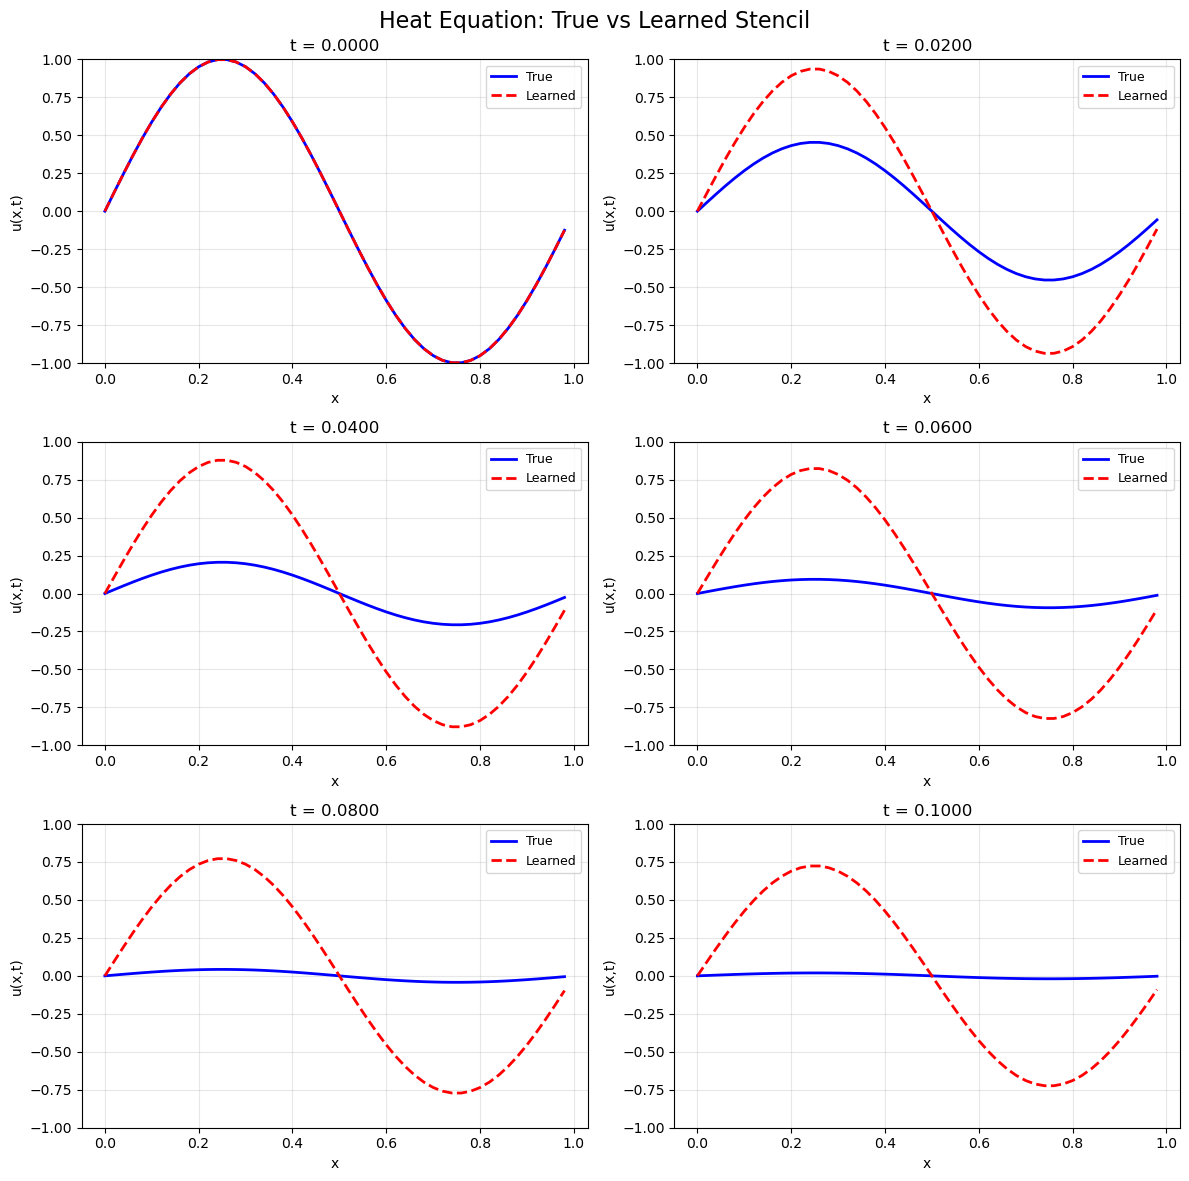

In [ ]:
import matplotlib.pyplot as plt

# Roll out the learned stencil and compare to training data
print("\nGenerating comparison plot...")

# Simulate with learned stencil
D_learned = build_learnableStencil_periodic(N, stencil_coeffs.data, device=device)
A_learned = torch.eye(N, device=device) - dt * D_learned

u_learned_history = torch.zeros(M + 1, N, device=device)
u_learned_history[0] = u_true_snapshots[0].clone()  # Initial condition

for step in range(M):
    u_learned_history[step + 1] = torch.linalg.solve(A_learned, u_learned_history[step])

# Convert to numpy for plotting
x_plot = x_grid.cpu().numpy()
t_plot = t_grid.cpu().numpy()
u_true_plot = u_true_snapshots.cpu().numpy()
u_learned_plot = u_learned_history.cpu().numpy()

# Create comparison plot with 3x2 grid (6 snapshots)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Heat Equation: True vs Learned Stencil', fontsize=16)

# Select 6 evenly spaced time snapshots
num_snapshots = 6
snapshot_indices = [int(i * M / (num_snapshots - 1)) for i in range(num_snapshots)]
# Make sure the last index is exactly M
snapshot_indices[-1] = M

for idx, snap_idx in enumerate(snapshot_indices):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    ax.plot(x_plot, u_true_plot[snap_idx], 'b-', linewidth=2, label='True')
    ax.plot(x_plot, u_learned_plot[snap_idx], 'r--', linewidth=2, label='Learned')
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('u(x,t)', fontsize=10)
    ax.set_title(f't = {t_plot[snap_idx]:.4f}', fontsize=12)
    ax.set_ylim([-1, 1])  # Fix y-axis to [-1, 1] for easy visualization of decay
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Your turn

Play with this code! Change the number of training steps so that it runs until the error bottoms out. 
- How low does the error get? Compare this to the finite difference solution we generated in HW1 - what kind of $h,k$ resolution did you need there to get to the same error?
- Look at the numerical value for the stencil that you solved for. Compare this to the stencils that we've discussed in class - how and why is it different?
- Run the same learned stencil for a different initial condition and analytic solution (e.g. $\exp{(-4π² K^2 t)} \sin(2π K x)$). What is the effect on the performance and why?